In [1]:
import json
import pandas as pd
import dotenv
from tqdm import tqdm
from langchain_openai import ChatOpenAI
import networkx as nx
from chatsky_llm_autoconfig.graph import Graph
from chatsky_llm_autoconfig.dialogue import Dialogue
import chatsky_llm_autoconfig.metrics.automatic_metrics as auto_metrics
import chatsky_llm_autoconfig.metrics.llm_metrics as llm_metrics
from chatsky_llm_autoconfig.algorithms.dialogue_generation import DialoguePathSampler, DialogueSampler

dotenv.load_dotenv()

/home/askatasuna/.cache/pypoetry/virtualenvs/chatsky-llm-autoconfiguration-VcuUrJCU-py3.11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


True

In [2]:
with open('data.json', encoding="utf-8") as f:
    data = json.load(f)
print(len(data))

10


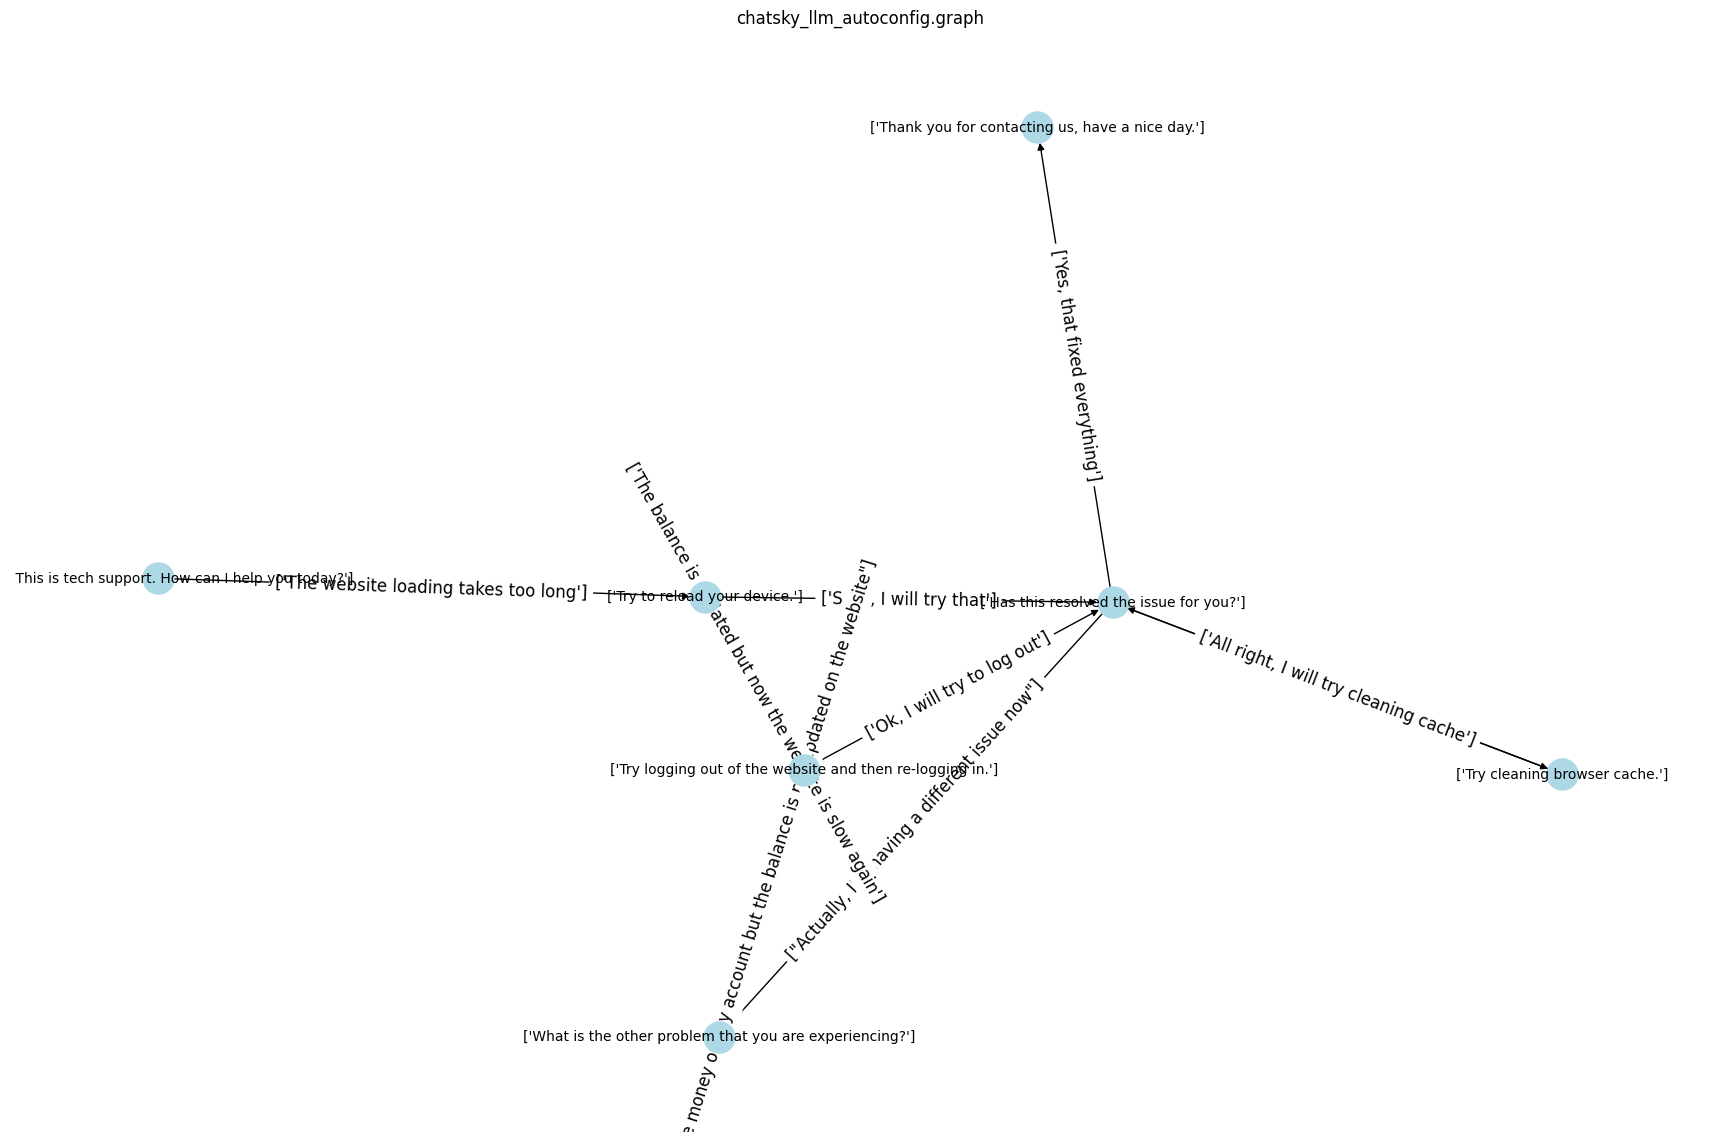

In [3]:
G = Graph(data[0]['graph'])
G.visualise()

In [4]:
nx.find_cycle(G.graph)

[(3, 4), (4, 3)]

In [5]:
G.graph.nodes[1]

{'theme': None,
 'label': 'welcome and ask',
 'utterances': ['Hello! This is tech support. How can I help you today?']}

In [6]:
data_json = {"graph": {
            "nodes": [
                {
                    "id": 1,
                    "label": "welcome and ask",
                    "is_start": True,
                    "utterances": [
                        "Hello! This is tech support. How can I help you today?"
                    ]
                },
                {
                    "id": 2,
                    "label": "reload",
                    "is_start": False,
                    "utterances": [
                        "Try to reload your device."
                    ]
                },
                {
                    "id": 3,
                    "label": "check if helped",
                    "is_start": False,
                    "utterances": [
                        "Has this resolved the issue for you?"
                    ]
                },
                {
                    "id": 4,
                    "label": "verification",
                    "is_start": False,
                    "utterances": [
                        "Try cleaning browser cache."
                    ]
                },
                {
                    "id": 5,
                    "label": "ask about additional problem",
                    "is_start": False,
                    "utterances": [
                        "What is the other problem that you are experiencing?"
                    ]
                },
                {
                    "id": 6,
                    "label": "solution for balance",
                    "is_start": False,
                    "utterances": [
                        "Try logging out of the website and then re-logging in."
                    ]
                },
                {
                    "id": 7,
                    "label": "end",
                    "is_start": False,
                    "utterances": [
                        "Thank you for contacting us, have a nice day."
                    ]
                }
            ],
            "edges": [
                {
                    "source": 1,
                    "target": 2,
                    "utterances": [
                        "The website loading takes too long"
                    ]
                },
                {
                    "source": 2,
                    "target": 3,
                    "utterances": [
                        "Sure, I will try that"
                    ]
                },
                {
                    "source": 3,
                    "target": 4,
                    "utterances": [
                        "No, it did not work "
                    ]
                },
                {
                    "source": 4,
                    "target": 3,
                    "utterances": [
                        "All right, I will try cleaning cache"
                    ]
                },
                {
                    "source": 3,
                    "target": 7,
                    "utterances": [
                        "Yes, that fixed everything"
                    ]
                },
                {
                    "source": 3,
                    "target": 5,
                    "utterances": [
                        "Actually, I'm having a different issue now"
                    ]
                },
                {
                    "source": 5,
                    "target": 6,
                    "utterances": [
                        "I've put some money on my account but the balance is not updated on the website"
                    ]
                },
                {
                    "source": 6,
                    "target": 3,
                    "utterances": [
                        "Ok, I will try to log out"
                    ]
                },
                {
                    "source": 6,
                    "target": 2,
                    "utterances": [
                        "The balance is updated but now the website is slow again"
                    ]
                }
            ]
        }}

In [7]:
all_utterances = set([x[0] for x in list(nx.get_node_attributes(G.graph, "utterances").values())] + [x[0] for x in list(nx.get_edge_attributes(G.graph, "utterances").values())])

In [8]:
all_utterances

{"Actually, I'm having a different issue now",
 'All right, I will try cleaning cache',
 'Has this resolved the issue for you?',
 'Hello! This is tech support. How can I help you today?',
 "I've put some money on my account but the balance is not updated on the website",
 'No, it did not work ',
 'Ok, I will try to log out',
 'Sure, I will try that',
 'Thank you for contacting us, have a nice day.',
 'The balance is updated but now the website is slow again',
 'The website loading takes too long',
 'Try cleaning browser cache.',
 'Try logging out of the website and then re-logging in.',
 'Try to reload your device.',
 'What is the other problem that you are experiencing?',
 'Yes, that fixed everything'}

In [10]:
dialogue = []
for e in list(nx.edge_dfs(G.graph, 1)):
    # print("assistant:", G.graph.nodes[e[0]].get("utterances")[0])
    dialogue.append({'participant': 'assistant', 'text': G.graph.nodes[e[0]].get("utterances")[0]})
    # print("user:", G.graph.edges[e].get("utterances")[0])
    dialogue.append({'participant': 'user', 'text': G.graph.edges[e].get("utterances")[0]})
    if list(G.graph.successors(e[1])) == []:
        dialogue.append({'participant': 'assistant', 'text': G.graph.nodes[e[1]].get("utterances")[0]})

# print(*dialogue, sep="\n")
d = Dialogue().from_list(dialogue, validate=False)

In [11]:
print(d)

assistant: Hello! This is tech support. How can I help you today?
user: The website loading takes too long
assistant: Try to reload your device.
user: Sure, I will try that
assistant: Has this resolved the issue for you?
user: No, it did not work 
assistant: Try cleaning browser cache.
user: All right, I will try cleaning cache
assistant: Has this resolved the issue for you?
user: Yes, that fixed everything
assistant: Thank you for contacting us, have a nice day.
assistant: Has this resolved the issue for you?
user: Actually, I'm having a different issue now
assistant: What is the other problem that you are experiencing?
user: I've put some money on my account but the balance is not updated on the website
assistant: Try logging out of the website and then re-logging in.
user: Ok, I will try to log out
assistant: Try logging out of the website and then re-logging in.
user: The balance is updated but now the website is slow again


In [10]:
auto_metrics.all_utterances_present(G, [d])

True